## Проект: "Исследование поведения пользователей мобильного приложения по продаже продуктов питания"

Цель проекта: разобраться - как ведут себя пользователи мобтльного приложения и ответить на вопрос - повлияет ли изменение шрифта в мобильном приложении на поведение пользователей/воронку.

### Ход проекта:
#### Открытие и изучение данных
#### Предобработка данных
#### Анализ данных
#### Анализ воронки событий
#### Анализ результатов эксперимента

##### Описание данных: 

Каждая запись в логе — это действие пользователя, или событие.

EventName — название события;

DeviceIDHash — уникальный идентификатор пользователя;

EventTimestamp — время события;

ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

#### Открытие и изучение данных

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as stats
from cmath import sqrt
from plotly import graph_objects as go
from statsmodels.stats.proportion import proportions_ztest

In [2]:
try:
    df = pd.read_csv('logs_exp.csv',delimiter = "\t")
except:
    df = pd.read_csv('/datasets/logs_exp.csv',delimiter = "\t")

In [3]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Мы открыли и изучили данные, видим, что нужно привести названия столбцов к нижнему регистру, привести EventTimestamp в формат даты и приступить к предобработке данных.

#### Предобработка данных

In [4]:
df.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'user_id', 
                   'EventTimestamp':'event_time_stamp','ExpId':'exp_id'}, inplace=True)
df['event_name'] = df['event_name'].str.lower()
df.head()

,event_name,user_id,event_time_stamp,exp_id
0,mainscreenappear,4575588528974610257,1564029816,246
1,mainscreenappear,7416695313311560658,1564053102,246
2,paymentscreensuccessful,3518123091307005509,1564054127,248
3,cartscreenappear,3518123091307005509,1564054127,248
4,paymentscreensuccessful,6217807653094995999,1564055322,248


In [5]:
df['event_time'] = pd.to_datetime(df['event_time_stamp'], unit='s')
df['event_date'] = df['event_time'].dt.floor('D')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   event_name        244126 non-null  object        
 1   user_id           244126 non-null  int64         
 2   event_time_stamp  244126 non-null  int64         
 3   exp_id            244126 non-null  int64         
 4   event_time        244126 non-null  datetime64[ns]
 5   event_date        244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


,event_name,user_id,event_time_stamp,exp_id,event_time,event_date
0,mainscreenappear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,mainscreenappear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,paymentscreensuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,cartscreenappear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,paymentscreensuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [6]:
df.duplicated().sum()

413

In [7]:
df[df.duplicated()].head()

,event_name,user_id,event_time_stamp,exp_id,event_time,event_date
453,mainscreenappear,5613408041324010552,1564474784,248,2019-07-30 08:19:44,2019-07-30
2350,cartscreenappear,1694940645335807244,1564609899,248,2019-07-31 21:51:39,2019-07-31
3573,mainscreenappear,434103746454591587,1564628377,248,2019-08-01 02:59:37,2019-08-01
4076,mainscreenappear,3761373764179762633,1564631266,247,2019-08-01 03:47:46,2019-08-01
4803,mainscreenappear,2835328739789306622,1564634641,248,2019-08-01 04:44:01,2019-08-01


In [8]:
round((df.duplicated().sum()/len(df)*100),2)

0.17

Причиной дубликатов может быть какой-то технический сбой, например, юзер, зашедший в единицу времени засчитался несколько раз. В любом случае, так как дубликатов - незначительное количество, можем смело удалить:

In [9]:
df = df.drop_duplicates().reset_index(drop=True)
df

,event_name,user_id,event_time_stamp,exp_id,event_time,event_date
0,mainscreenappear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,mainscreenappear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,paymentscreensuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,cartscreenappear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,paymentscreensuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
243708,mainscreenappear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
243709,mainscreenappear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
243710,mainscreenappear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
243711,mainscreenappear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


Теперь разберемся с неявными дубликатами. Например, у некоторых записей могут совпадать все колонки кроме id. Такое может происходить из-за сбора данных из разных баз данных и/или из-за сбоя при логировании.

In [10]:
df['event_name'].value_counts()

mainscreenappear           119101
offersscreenappear          46808
cartscreenappear            42668
paymentscreensuccessful     34118
tutorial                     1018
Name: event_name, dtype: int64

In [11]:
df[df.duplicated(subset=['event_name', 'event_time_stamp', 'exp_id'])].head(10)

,event_name,user_id,event_time_stamp,exp_id,event_time,event_date
943,mainscreenappear,1095070338410354790,1564560839,246,2019-07-31 08:13:59,2019-07-31
2113,mainscreenappear,3807928414254040303,1564607965,247,2019-07-31 21:19:25,2019-07-31
2139,offersscreenappear,6224642068766507557,1564608063,248,2019-07-31 21:21:03,2019-07-31
2211,mainscreenappear,3613025750924969400,1564608547,247,2019-07-31 21:29:07,2019-07-31
2428,mainscreenappear,719912814612086941,1564610521,248,2019-07-31 22:02:01,2019-07-31
3307,offersscreenappear,3511569580412335882,1564625575,246,2019-08-01 02:12:55,2019-08-01
3460,mainscreenappear,4255978104192120227,1564627154,247,2019-08-01 02:39:14,2019-08-01
3462,offersscreenappear,4379626023801207145,1564627163,247,2019-08-01 02:39:23,2019-08-01
3512,mainscreenappear,499118262689586521,1564627836,247,2019-08-01 02:50:36,2019-08-01
3631,offersscreenappear,5422877498318042547,1564628735,246,2019-08-01 03:05:35,2019-08-01


In [12]:
len(df[df.duplicated(subset=['event_name', 'event_time_stamp', 'exp_id'])])

6868

In [13]:
len(df[df.duplicated(subset=['event_name', 'event_time_stamp', 'exp_id'])])/len(df)*100

2.818068794032325

Неявных дубликатов - всего 2.8%. Можем оставить неявные дубликаты, не опасаясь, что это повлияет на дальнейший анализ данных.

Вывод:
мы убедились, что в данных нет пропусков, привели содержание столбцов к нижнему регистру, заменили названия столбцов на удобные для нас, привели типы данных в нужный формат и добавили два столбца - столбец даты и времени, а также отдельный столбец дат. Так же мы проверили данные на явные и неявные дубликаты. Можем приступать к следующему шагу.

#### Анализ данных

In [14]:
print('Всего событий в логе:', len(df))

Всего событий в логе: 243713


In [15]:
print('Всего пользователей:',len(df['user_id'].value_counts()))

Всего пользователей: 7551


In [16]:
df_pivot = df.pivot_table(index='user_id', values ='event_name', aggfunc='count' ).reset_index()
round(df_pivot['event_name'].mean(),2)
print('В среднем на пользователя приходится:', round(df_pivot['event_name'].mean(),2),'событий')

В среднем на пользователя приходится: 32.28 событий


In [17]:
print('Минимальная дата:', df['event_date'].min().strftime('%d.%m.%y'))
print('Максимальная дата:', df['event_date'].max().strftime('%d.%m.%y'))
print ('Даннные за:', (df['event_date'].max() - df['event_date'].min()) / np.timedelta64 ( 1 , 'D'), 'дней')

Минимальная дата: 25.07.19
Максимальная дата: 07.08.19
Даннные за: 13.0 дней


Построим гистограмму по дате и времени:

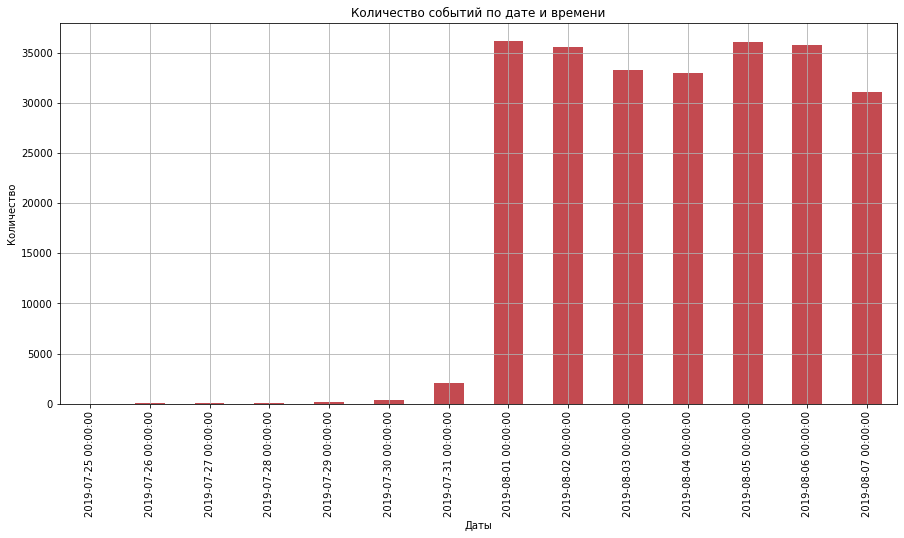

In [18]:
plt.subplots()
df.groupby('event_date')['event_time'].agg('count').plot(kind='bar',stacked=True, figsize=(15, 7), color = '#c34a50', grid = True)
plt.title('Количество событий по дате и времени')
plt.ylabel('Количество')
plt.xlabel('Даты')
plt.show()

По графику мы видим, что имеет смысл брать данные только за август -  с первого по седьмое.

In [19]:
new_df = (df['event_date']>'2019-07-31')
new_df = df.loc[new_df]
new_df['event_date'].min()

Timestamp('2019-08-01 00:00:00')

Проверим - сколько данных отбросили:

In [20]:
old_df = (df['event_date']<='2019-07-31')
old_df = df.loc[old_df]
print('Количество событий по отброшенным данным',len(old_df))
print('Количество событий в процентах:',round(len(old_df)/len(df)*100,2),'%')
print()
print('Всего пользователей по отброшенным данным:',len(old_df['user_id'].value_counts()))
print('Всего пользователей в процентах:',round(len(old_df['user_id'].value_counts())/len(df['user_id'].value_counts()),2),'%')

Количество событий по отброшенным данным 2826
Количество событий в процентах: 1.16 %

Всего пользователей по отброшенным данным: 1451
Всего пользователей в процентах: 0.19 %


Мы отбросили около процента событий и уникальных пользователей, потому можем об этом не беспокоиться. Проверим, что у нас есть пользователи из всех трех экспериментальных групп:

In [21]:
a = new_df.groupby('exp_id').agg(unique_users = ('user_id','nunique')).reset_index()
a

,exp_id,unique_users
0,246,2484
1,247,2513
2,248,2537


In [22]:
print('Размер выборки группы 246 в %:',round(a.unique_users[0]/a.unique_users.sum(),2))
print('Размер выборки группы 247 в %:',round(a.unique_users[1]/a.unique_users.sum(),2))
print('Размер выборки группы 248 в %:',round(a.unique_users[2]/a.unique_users.sum(),2))

Размер выборки группы 246 в %: 0.33
Размер выборки группы 247 в %: 0.33
Размер выборки группы 248 в %: 0.34


Убудились, что у нас примерно в равных пропорциях остались пользователи из всех трех экспериментальных групп, разница между количеством пользователей не превышает 1% - можем приступать к следующему шагу:

#### Анализ воронки событий

In [23]:
new_df['event_name'].value_counts()

mainscreenappear           117328
offersscreenappear          46333
cartscreenappear            42303
paymentscreensuccessful     33918
tutorial                     1005
Name: event_name, dtype: int64

Мы видим, что начало воронки- главный экран видит большинство пользователей (что логично).
Затем идет экран с офферами, следом - экран с корзиной, затем  - экран оплаты, затем руководство. Нельзя считать руководство -завершающим этапом воронки. Это скорее отдельный блок для пользователей, у которых возникли вопросы. 

In [24]:
new_df['user_id'].value_counts()

6304868067479728361    2307
197027893265565660     1996
4623191541214045580    1768
6932517045703054087    1439
1754140665440434215    1221
                       ... 
9131338384454321904       1
4129178667624237055       1
4715449382983361650       1
7914773194539807942       1
921624063626441313        1
Name: user_id, Length: 7534, dtype: int64

В базе есть юзеры, кто совершил всего одно событие(например, зашел на главный экран и потом ушел) и совершил множество событий, в том числе покупал в приложении уже много раз:

In [25]:
pay_user = new_df.query('event_name == "paymentscreensuccessful"')
pay_user['user_id'].value_counts()

6304868067479728361    1085
197027893265565660      865
4623191541214045580     762
1754140665440434215     570
3337471580007169353     525
                       ... 
5962451360444563367       1
8733467333849279674       1
7522230815377799330       1
1202921123440807590       1
4164287718073415198       1
Name: user_id, Length: 3539, dtype: int64

Нельзя равнять их с теми, кто увидел приложение в первый раз.
Посчитаем, сколько пользователей совершали каждое из этих событий и долю пользователей, которые хоть раз совершали событие:

In [26]:
unique_users = new_df.groupby('event_name', 
               as_index = False).agg(unique_count = ('user_id','nunique')).sort_values(by = 'unique_count',ascending=False)

unique_users['total_fraction,%'] = round(unique_users['unique_count']/new_df['user_id'].nunique()*100,2)
unique_users = unique_users.reset_index(drop=True)
unique_users

,event_name,unique_count,"total_fraction,%"
0,mainscreenappear,7419,98.47
1,offersscreenappear,4593,60.96
2,cartscreenappear,3734,49.56
3,paymentscreensuccessful,3539,46.97
4,tutorial,840,11.15


Исключим  tutorial из воронки. Воронка пользователя выглядит следующим образом:

In [27]:
funnel_users = unique_users.query('event_name!="tutorial"')
funnel_users

,event_name,unique_count,"total_fraction,%"
0,mainscreenappear,7419,98.47
1,offersscreenappear,4593,60.96
2,cartscreenappear,3734,49.56
3,paymentscreensuccessful,3539,46.97


In [ ]:
fig = go.Figure(
go.Funnel(
y = funnel_users['event_name'],
x = funnel_users['unique_count'] ,
textinfo = "value+percent initial",
marker = {'color':['#c34a50','#c34a50','#c34a50','#c34a50']},)
)
fig.show()


Посчитаем какая доля пользователей проходит на следующий шаг воронки.

In [ ]:
funnel_fraction = unique_users.drop('total_fraction,%', axis=1)
funnel_fraction = funnel_fraction.query('event_name!="tutorial"')
funnel_fraction['prc,%'] = round(unique_users.unique_count/unique_users.unique_count.shift(1)*100,2)
funnel_fraction

Мы видим, что с главного экрана до блока с офферами доходит только 62% юзеров, то есть на первом шаге теряется больше всего пользователей - аж 40%. От первого события до оплаты доходит 48% юзеров.

Мы построили воронку событий, посчитали - какая доля пользователей проходит на следующий шаг воронки, а так же увидели самое слабое место в воронке - переход с первого шага на второй (теряется около 40% юзеров). Конверсия из первого шага в оплату составляет 47,7%, что считается хорошей конверсией в продажах. 
Можем переходить к следующему шагу:

In [ ]:
print('Конверсия из первого шага в оплату, %:', round(funnel_fraction['unique_count'][3]/funnel_fraction['unique_count'][0],2))

In [ ]:
funnel_fraction['prc,%']= funnel_fraction['prc,%'].fillna(100)
funnel_fraction['diff']=abs(funnel_fraction ['prc,%'] - funnel_fraction ['prc,%'].shift(1))
funnel_fraction

Самая большая разница в конверсии - при переходе с главное страницы на страницу с офферами.

#### Анализ результатов эксперимента

Главная цель А/А-теста — показать, можно ли доверять результатам эксперимента, который будет запущен в тех же условиях, но уже с разными вариантами страницы. Посчитаем количество пользователей в каждой экспериментальной группе: 

In [ ]:
df_group = new_df.groupby('exp_id', 
               as_index = False).agg(unique_count = ('user_id','nunique')).sort_values(by = 'unique_count',
                                                                                       ascending=False).reset_index(drop=True)
df_group

In [ ]:
diff = 1 - df_group.unique_count[2] / df_group.unique_count[1]
print('Разница между выборками 246 и 247 - {:.2%}'.format(diff))

Количество пользователей в различных группах различается не более, чем на 1%. Это является одним из критериев успешного А/А теста. Выберем самое популярное событие:

In [ ]:
gr_246 = new_df.query('exp_id==246')
gr_247 = new_df.query('exp_id==247')
len(gr_246.merge(gr_247, on = 'user_id', how = 'inner'))


In [ ]:
group_df = new_df.pivot_table(index='event_name', columns='exp_id', values='user_id', aggfunc='nunique')
group_df.reset_index()

Самое популярное событие - mainscreenappear	 - выход на главный экран у всех групп, что ожидаемо. А платят больше всего в 246 группе.

Создадим функцию, считающую статистическую значимость между группами. Датафрейм будем обрабатывать внутри функции, группы будем передавать в виде списка.

Сформулируем гипотезы

Н0 - различия между экспериментальными группами, совершившими указанное событие, статистически не значимы

Н1 - различия между экспериментальными группами, совершившими указанное событие, статистически значимы

Для проверки гипотезы используем один из самых популярных и точных способов  — A/B-тест.
Пороговое значение alpha примем за 1%, так как мы ожидаем увидеть степень различия между группами не больше 10% (больше - бывает очень редко и было бы заметно и без тестов).

Перед тем как начать A/B-тест, убедимся, что:
на результаты не влияют аномалии и выбросы;
инструмент «деления» трафика работает безошибочно;
данные отправляются в системы аналитики корректно.
Для этого проведем A/A-тест. 

In [ ]:
new_df.head()

In [ ]:
def test(new_df, group_ex, alpha):
    #найдем уникальных пользователей в каждой группе
    users = [new_df.query('exp_id == @group_id')['user_id'].nunique() for group_id in group_ex]
    #перебираем все экспериментальные группы для каждого события, считаем количество пользователей и долю
    for event in new_df.event_name.unique():
        events = [new_df.query('exp_id == %d and event_name == "%s"' % (group_id, event))['user_id'].nunique() for group_id in group_ex]
        # сравниваем кол-во уникальных юзеров на каждом шаге группы к кол-ву уникальных юзеров в этой группе всего
        p1 = events[0] / users[0] #считаем долю для 1 группы
        p2 = events[1] / users[1] #считаем долю для 2 группы
        
        p_combined = sum(events) / sum(users) 
        
        difference = p1 - p2 # разница в датасетах
        
        z_value = difference / sqrt(
            p_combined * (1 - p_combined) * (1 / users[0] + 1 / users[1]) #считаем z-value, которая покажет, насколько она далека от среднего значения точки данных
        )
        
        distr = stats.norm(0, 1) #распределение
        p_value = (1 - distr.cdf(abs(z_value))) * 2 #считаем p-value
        
        print(event)
        print(p1, p2)
        print('p-значение: ', p_value)
        #сравниваем p-value и alpha
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу по событию %s: между долями есть значимая разница' % (event))
        else:
            print('Не получилось отвергнуть нулевую гипотезу по событию %s: нет оснований считать доли разными' % (event))
            
        print(' ')
        print(' ')

Проведем A/A тестирование - это проверка всего эксперимента на валидность:

In [ ]:
test(new_df, [246, 247], 0.01)

Различия во всех событиях между 246 и 247 группами статистически не значимы. А/А тест прошел успешно.
Переходим к A/B тесту - здесь важно понять, есть ли у нас статистически значимые различия.
Проверим все три возможных комбинации 246, 247 и 248 группы.

In [ ]:
test(new_df, [246, 248], 0.01)

Различия между группами 246 и 248 статистически не значимы. Мы имеем высокую вероятность случайных различий между показателями, обусловленных обычной дисперсий/вариацией в данных, а не реальной разницей.

In [ ]:
test(new_df, [247, 248], 0.01)

Различия между группами 247 и 248 статистически не значимы, т.е. различия могли получиться случайно.
Объединим 2 контрольные группы в одну(1)  и сравним с 248ой.

In [ ]:
combined = new_df.copy()
combined["exp_id"].replace({247: 1, 246:1}, inplace=True)
combined["exp_id"].value_counts()

In [ ]:
def test_c(combined, group_ex, alpha):
    #найдем уникальных пользователей в каждой группе
    users = [combined.query('exp_id == @group_id')['user_id'].nunique() for group_id in group_ex]
    #перебираем все экспериментальные группы для каждого события, считаем количество пользователей и долю
    for event in combined.event_name.unique():
        events = [combined.query('exp_id == %d and event_name == "%s"' % (group_id, event))['user_id'].nunique() for group_id in group_ex]
        # сравниваем кол-во уникальных юзеров на каждом шаге группы к кол-ву уникальных юзеров в этой группе всего
        p1 = events[0] / users[0] #считаем долю для 1 группы
        p2 = events[1] / users[1] #считаем долю для 2 группы
        
        p_combined = sum(events) / sum(users) 
        
        difference = p1 - p2 # разница в датасетах
        
        z_value = difference / sqrt(
            p_combined * (1 - p_combined) * (1 / users[0] + 1 / users[1]) #считаем z-value, которая покажет, насколько она далека от среднего значения точки данных
        )
        
        distr = stats.norm(0, 1) #распределение
        p_value = (1 - distr.cdf(abs(z_value))) * 2 #считаем p-value
        
        print(event)
        print(p1, p2)
        print('p-значение: ', p_value)
        #сравниваем p-value и alpha
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу по событию %s: между долями есть значимая разница' % (event))
        else:
            print('Не получилось отвергнуть нулевую гипотезу по событию %s: нет оснований считать доли разными' % (event))
            
        print(' ')
        print(' ')

In [ ]:
test_c(combined, [1, 248], 0.01)

Различия между объединенными группами и группой 248 статистически не значимы, результат может оказаться случайным.
Предварительно можно сделать вывод, что шрифт не влияет на пользователей.
Особенность множественного теста в том, что вероятность ошибки первого рода увеличивается с каждой новой проверкой гипотезы.
Чтобы снизить вероятность ложнопозитивного результата применим метод Бонферони.
Для этого поделим принятый уровень значимости (0.01) на число сравнений - 16 (4 пары групп и 4 события), которые проводят на одних и тех же данных, без сбора новых наблюдений для каждого теста.

С учетом поправки, альфа будет равна 0.01/16 = 0.0006.
Проверим гипотезу с новым значениям альфа:

In [ ]:
test(new_df, [246, 248], 0.0006)

In [ ]:
test(new_df, [247, 248], 0.0006)

In [ ]:
test_c(combined, [1, 248], 0.0006)

#### Вывод

Мы преобразовали даты в тип дат и провели предобработку данных.
Удалили явные дубликаты: 0.17%
Оставили неявные дубликаты - 2.8%. Из-за малого количества они не повлияют на результаты анализа.
Всего событий в логе: 243713
Всего уникальных пользователей: 7551
В среднем на пользователя приходится: 32.28 событий

Полные  данные были представлены только за август - с первого по седьмое, этот срез данных и был взят в анализ. В результате было отброшено только 2826 (1.16 %) событий и 1451(0.19 %) юзеров.


Проверили, количество пользователей из всех трех экспериментальных групп и убедились, что они представлены примерно в равном соотношении (разница не превышает 1%):
Размер выборки группы 246 в %: 0.33
Размер выборки группы 247 в %: 0.33
Размер выборки группы 248 в %: 0.34

Проанализировали воронку пользователя. 
Она состоит из:
* главного экрана 7419 пользователей (100%), на следующий шаг не доходит 38%
* экрана с офферами 4593 (62%), на следующий шаг не доходит 19%
* экрана с корзиной 3734 (50%), на следующий шаг не доходит 13,5%
* экрана с оплатой 3539 (48%)

На первом шаге теряется больше всего пользователей - аж 38%. 
От первого события до оплаты доходит 48% юзеров, что является хорошей конверсией в продажах.

Чтобы ответить на вопрос можно ли и нужно ли менять шрифт во всем приложении мы сформулировали гипотезы:
Н0 - различия между экспериментальными группами, совершившими указанное событие, статистически не значимы
Н1 - различия между экспериментальными группами, совершившими указанное событие, статистически значимы
Для проверки гипотезы использовали один из самых популярных и точных способов — A/B-тест. Пороговое значение alpha приняли  за 1%, так как мы ожидаем увидеть степень различия между группами не больше 10% (больше - бывает очень редко и было бы заметно и без тестов).
Перед тем как начать A/B-тест, убедились, что: на результаты не влияют аномалии, выбросы  и технические ошибки сбора данных. и успешно провели A/A-тест.

По итогам всех тестов-не получилось отвергнуть нулевую гипотезу и считать конверсии для групп разными. Изменение шрифта не повлияло значимо на показатели воронки. Можно менять шрифт, или не менять - это не повлияет на конверсии.
